In [2]:
import bayes3d as b
import numpy as np
import jax.numpy as jnp
import jax

import utils

In [3]:
import importlib
importlib.reload(utils)
from utils import load_img, scale_remove_and_setup_renderer, add_meshes_to_renderer, c2f_jit, cps_to_pose, get_grids

In [4]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


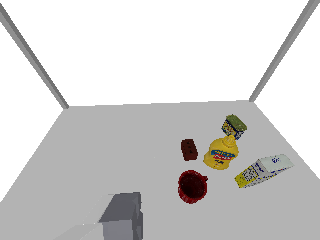

In [5]:
rgbd = load_img("problems/img3.pickle")
b.get_rgb_image(rgbd.rgb)

In [6]:
rgbd_scaled_down, obs_img, table_pose, cloud, depth_im = scale_remove_and_setup_renderer(rgbd, scaling_factor=0.3)

b.clear()
b.show_cloud("1", cloud)
b.show_pose("table", table_pose)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (96, 96, 1024)


In [7]:
b.clear()
b.show_cloud("Obs without table or too-far points", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)

In [8]:
add_meshes_to_renderer()

In [9]:
grid_param_sequence = [
    (2.0, jnp.pi, (15, 15, 15)),
    (0.5, jnp.pi * 3/4, (15, 15, 15)),
    (0.4, jnp.pi * 1/2, (15, 15, 15)),
    (0.05, jnp.pi * 1/3, (15,15,15)),
    (0.02, jnp.pi * 1/4, (9,9,51)),
    (0.01, jnp.pi * 1/5, (15,15,15)),
    (0.01, 0.0, (31,31,1)),
    (0.05, 0.0, (31,31,1))
]

In [13]:
key = jax.random.PRNGKey(30)
cps = jnp.zeros((0,3))
indices = jnp.array([], dtype=jnp.int32)

In [16]:
best_score = -np.inf
best_index = -1
best_cps = None
best_indices = None
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])

for i in range(6):
    for next_index in range(len(b.RENDERER.model_box_dims)):
        potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
        potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])
        potential_cps, score, _ = c2f_jit(table_pose, potential_cps, potential_indices, len(potential_indices) - 1, get_grids(grid_param_sequence), obs_img)
        print(score)
        if score > best_score:
            best_index = next_index
            best_score = score
            best_cps = potential_cps
            best_indices = potential_indices
    cps = best_cps
    indices = best_indices

b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_pose("table", table_pose)
poses = cps_to_pose(cps, indices, table_pose)
for i in range(len(poses)):
    b.show_trimesh(f"{i}", b.RENDERER.meshes[best_indices[i]])
    b.set_pose(f"{i}", poses[i])

46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582
46.614582


In [128]:
best_score = 0.0
best_index = -1
best_cps = None
best_indices = None
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])
next_index = 18

potential_indices = jnp.concatenate([indices, jnp.array([next_index])])
potential_cps = jnp.concatenate([cps, jax.random.uniform(key, shape=(1,3,),minval=low, maxval=high)])

importlib.reload(utils)
from utils import cps_to_pose_parallel, score_vmap
cps = potential_cps
indices = potential_indices
grid = get_grids(grid_param_sequence)[0]
cps_expanded = jnp.repeat(cps[None,...], grid.shape[0], axis=0)
cp_poses = cps_to_pose_parallel(cps_expanded, indices, table_pose) # (g, n, 4, 4)
rendered_images = b.RENDERER.render_many(cp_poses, indices)[...,:3] # (g, h, w, 3)
scores = jax.jit(score_vmap)(rendered_images, obs_img)
idx = jnp.argmax(scores)

b.clear()
b.show_cloud("obs", obs_img.reshape(-1,3))
b.show_cloud("rendered0", rendered_images[idx, ...].reshape(-1, 3))


In [144]:
# b.RENDERER.render_many(cp_poses, indices)[...,:3]
b.RENDERER.render_many(
    jnp.zeros((3375, 0, 4, 4)),
    jnp.zeros((0,)).astype(int)
)

XlaRuntimeError: UNKNOWN: <unknown>:0: error: expected 1 dynamic stride values
<unknown>:0: note: see current operation: %2 = "memref.reinterpret_cast"(%1) <{operandSegmentSizes = array<i32: 1, 0, 0, 0>, static_offsets = array<i64: 0>, static_sizes = array<i64: 3375, 0, 4, 4>, static_strides = array<i64: -9223372036854775808, 16, 4, 1>}> : (memref<0x3375x4x4xf32>) -> memref<3375x0x4x4xf32>


In [120]:
near_rendered_pts = (np.linalg.norm(rendered_images[idx, ...], axis=-1) < 1000.)

In [121]:
distances = jnp.linalg.norm(obs_img - rendered_images[idx, ...], axis=-1)
width = 0.02

In [122]:
vals = (distances < width/2) / width

In [124]:
vals.mean()

Array(0.07957176, dtype=float32)

In [125]:
penalties = ( (distances > 2*width) * near_rendered_pts  / width )

In [126]:
penalties.mean()

Array(1.0778357, dtype=float32)

In [127]:
(vals - penalties).mean()

Array(-0.9982639, dtype=float32)